# DFaP Effect Demonstration

## Related Functions

In [ ]:
import os
import sys
import torch
from torchvision import transforms, utils
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.nn import functional as F 
from torch.autograd import Variable
from torch import nn, optim
from models import ResNet.ResNet34 as ResNet34
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from math import exp
import shutil
import warnings


warnings.filterwarnings('ignore')
BATCH_SIZE = 50
 
def show_batch(imgs):
    grid = utils.make_grid(imgs,nrow=10)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

def default_loader(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((32, 32))
    return img


class MyDataset(Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1])))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)


In [ ]:
'''
CAM Filtering and Erasure.
'''
def show_weight(weight_n):
    score = [[] for a in range(weight_n.shape[1])]
    for j in range(weight_n.shape[1]):
        filter_count = {}
        for i in range(256):
            filter_count[i] = weight_n[i][j]
        list1 = sorted(filter_count.items(), key=lambda x: x[1], reverse=True)
        x = []
        y = []
        for i in range(100):
            x.append(list1[i][0])
            y.append(list1[i][1])
            score[j].append(list1[i][0])
    return score

def getCAMdata(path, label, model): 
    true_label = label
    data = MyDataset(txt=path, 
              transform=transforms.Compose([
                transforms.Resize([32,32]),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
              )

    loader = DataLoader(data, batch_size=50, shuffle=False)
    pred = np.array([])
    y_sum = np.array([])
    feature = []
    model = model.eval()
    with torch.no_grad():
        running_correct = 0
        total = 0
        for i, (x, label) in enumerate(loader):
            if i == 0:
              x_raw = x.numpy()
              y_raw = label.numpy()
            else:
              x_raw = np.append(x_raw,x.numpy(),axis=0)
              y_raw = np.append(y_raw,label.numpy(),axis=0)
            data = x
            data = data.cuda()
            
            y_label = label
            y_label = y_label.type(torch.LongTensor)
            y_label = y_label.cuda()
            output, attack_feature = model(data)
            _, predicted = torch.max(output.data, 1)                            
            total = total + y_label.size(0)
            running_correct = running_correct + (predicted == y_label).sum()
            predicted = predicted.cpu().numpy()
            pred = np.append(pred, predicted)
            y_sum = np.append(y_sum,y_label.cpu().numpy())
            for i in range(len(attack_feature)):                                 
                attack_feature[i] = attack_feature[i].detach().numpy() 
            feature.append(attack_feature[-1]) 
    attack_feature = feature[0]
    for i in range(len(feature)):
      if i != 0:
        attack_feature = np.concatenate((attack_feature,feature[i]),axis=0)
    pred = list(pred)
    err_num = []
    for i in range(len(pred)):
      if pred[i] != true_label:
        err_num.append(i)
    return x_raw, y_raw, attack_feature, err_num

def getdetails_percent(feature, weight_n, ori_f, mylabel, path, save_filepath, erase_method, percent,target_label=False):
    res_details = [] 
    res_details_act = []
    res_derails_act_cam = []
    maskes = []
    maskes_lowWeight = []
    file_names = []
    with open(path, "r") as f:
      for line in f.readlines():
        line = line.strip('\n')[:-2] 
        file_names.append(line)

    for i in range(feature.shape[0]):
        temp = np.zeros([feature.shape[2], feature.shape[3]])
        for j in range(feature.shape[1]):
            temp = temp + weight_n[j][int(mylabel[i])] * feature[i][j]
        temp_ori = cv2.resize(temp, (32, 32), interpolation=cv2.INTER_LINEAR)
        temp_ori_copy = temp_ori 
        res_details_act.append(temp_ori)
        mmax = np.max(temp_ori)
        th = mmax * percent
        mmin = np.min(temp_ori)
        th_low = mmin *1.5
        temp_ori = np.where(temp_ori >= th, 1, 0)
        f_details = temp_ori * ori_f[i]
        res_details.append(f_details)
        maskes.append(temp_ori)
        temp_ori_lowweight = np.where(temp_ori_copy <= th_low, 1, 0)
        maskes_lowWeight.append(temp_ori_lowweight)
   

    for i in range(len(res_details_act)):
      cam = (res_details_act[i] - res_details_act[i].min()) / (res_details_act[i].max() - res_details_act[i].min())
      cam = cam*255
      cam = cam.astype(np.uint8)
      heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
      if target_label:
        trans_ori_f = cv2.imread(file_names[i])
      else:
        trans_ori_f = cv2.imread(file_names[i])
      trans_ori_f = cv2.resize(trans_ori_f, (32, 32), interpolation=cv2.INTER_LINEAR)
      cover_pic = trans_ori_f
      lowWeight_pixel = []
    

      if erase_method == 'low_weight_erase':
        for k in range(len(maskes_lowWeight[i])):  
          for j in range(len(maskes_lowWeight[i][k])):
            if maskes_lowWeight[i][k][j] == 1:
              lowWeight_pixel.append(cover_pic[k][j])
        cnt = 0
        for k in range(len(maskes[i])): 
          for j in range(len(maskes[i][k])):
            if maskes[i][k][j] == 1:
              cover_pic[k][j] = lowWeight_pixel[cnt]
              cnt = (cnt+1)%len(lowWeight_pixel)

      if erase_method == 'black_erase':
        for k in range(len(maskes[i])):  #(32,32)
          for j in range(len(maskes[i][k])):
            if maskes[i][k][j] == 1:
              cover_pic[k][j] = cover_pic[k][j] * 0

      if erase_method == 'repair':
        repair_mask = np.where(maskes[i] >= 1,255,0)
        repair_mask = repair_mask.astype(np.uint8)
        cover_pic = cv2.inpaint(trans_ori_f, repair_mask, 3, cv2.INPAINT_TELEA)

      cv2.imwrite(save_filepath+str(i)+'.png', cover_pic)
      heatmap[np.where(cam <= 50)] = 0
      out = cv2.addWeighted(src1=trans_ori_f, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
      out = out.transpose((2,0,1))
      res_derails_act_cam.append(out)
    return np.array(res_details), np.array(res_details_act),np.array(res_derails_act_cam)

def network_dissection(feature):  
    print(feature.shape)                                  
    length = feature.shape[0]
    channel = feature.shape[1]
    filter = [[] for a in range(length)]                    
    for i in range(length):
        for j in range(channel): 
            sum = 0
            for m in range(feature.shape[2]):
                for n in range(feature.shape[3]):
                    sum = sum + feature[i][j][m][n]
            filter[i].append(sum)
    return filter

In [ ]:
'''
AutoEncoder Model.
'''
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3072, 2700),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2700, 3072),
            nn.Sigmoid()
        )

    def forward(self, x):
        batchsz = x.size(0)
        x = x.view(batchsz, 3072)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(batchsz, 3, 32, 32)
        return x

In [ ]:
'''
UNet Model.
'''
class DoubleConv(nn.Module):
 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, x):
        return self.double_conv(x)
 
class Down(nn.Module):
 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        ) 
    def forward(self, x):
        return self.maxpool_conv(x)
 
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()
    if bilinear:
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    else:
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)
 
 
    def forward(self, x1, x2, is_concat = True):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]]) 
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if is_concat == True:
          x = torch.cat([x2, x1], dim=1)
        else:
          x = x1
        return self.conv(x)
 
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
 
 
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
 
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
 
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4,)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
'''
MS-SSIM Loss Function.
'''
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, sigma, channel):
    _1D_window = gaussian(window_size, sigma).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

class MS_SSIM(torch.nn.Module):
    def __init__(self, size_average = True, max_val = 255):
        super(MS_SSIM, self).__init__()
        self.size_average = size_average
        self.channel = 3
        self.max_val = max_val
    def _ssim(self, img1, img2, size_average = True):

        _, c, w, h = img1.size()
        window_size = min(w, h, 11)
        sigma = 1.5 * window_size / 11
        window = create_window(window_size, sigma, self.channel).cuda()
        mu1 = F.conv2d(img1, window, padding = window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, window, padding = window_size//2, groups = self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = self.channel) - mu1_mu2

        C1 = (0.01*self.max_val)**2
        C2 = (0.03*self.max_val)**2
        V1 = 2.0 * sigma12 + C2
        V2 = sigma1_sq + sigma2_sq + C2
        ssim_map = ((2*mu1_mu2 + C1)*V1)/((mu1_sq + mu2_sq + C1)*V2)
        mcs_map = V1 / V2
        if size_average:
            return ssim_map.mean(), mcs_map.mean()

    def ms_ssim(self, img1, img2, levels=5):

        weight = Variable(torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).cuda())

        msssim = Variable(torch.Tensor(levels,).cuda())
        mcs = Variable(torch.Tensor(levels,).cuda())
        for i in range(levels):
            ssim_map, mcs_map = self._ssim(img1, img2)
            msssim[i] = ssim_map
            mcs[i] = mcs_map
            filtered_im1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            filtered_im2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
            img1 = filtered_im1
            img2 = filtered_im2

        value = (torch.prod(mcs[0:levels-1]**weight[0:levels-1])*
                                    (msssim[levels-1]**weight[levels-1]))
        return value


    def forward(self, img1, img2):

        return self.ms_ssim(img1, img2)

## Sample Examples

Backdoor Sample Example:


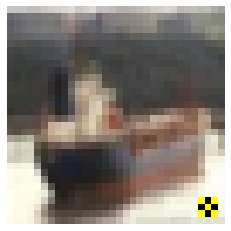


Clean Sample Example:


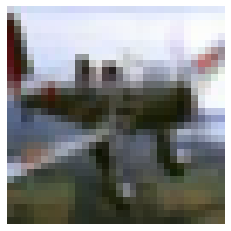

In [ ]:
print('Backdoor Sample Example:')
path = "./10_dataset/bk_data/1.png"
img = Image.open(path).convert('RGB')
img = img.resize((32 ,32))
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
plt.imshow(img)
plt.show()

print('\nClean Sample Example:')
path = './cifar10_dataset/train/0/aeroplane_s_000004.png'
img = Image.open(path).convert('RGB')
img = img.resize((32 ,32))
fig, ax=plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
plt.imshow(img)
plt.show()

## Setting

In [ ]:
'''
cover_dest_directory : Directory for storing samples after erasure and repair;
final_dest_directory : Directory for storing samples after DFaP;
model_addr : Address of Infected model;
threshold : Erasure repair threshold;
AE_threshold : Reselection mechanism threshold;
erase_method_choice : Erasure repair method(TELEA);
target_label : Backdoor attack target label;
total_TAR : For statistical TAR.
'''

cover_dest_directory = "./cover_data/"
final_dest_directory = "./DFaP_Cifar10_After_Repair"
os.mkdir('./DFaP_Cifar10_After_Repair') 
os.mkdir('./cover_data') 
model_addr = "./models/cifar10_pattern_Augment10%.pkl"
threshold = 0.5
AE_threshold = 0.03
erase_method_choice = 'repair'
target_label = 1
total_TAR = 0

## Backdoor samples filtering and purification effect

BK Sample Example:


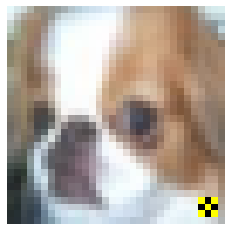

----------

BK Erasure Repair Sample Example:


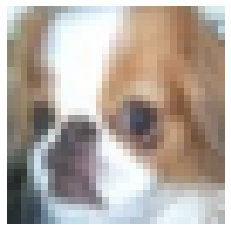

----------


BK FAR：0.000000%
----------

BK Erasure Repair Sample Example:


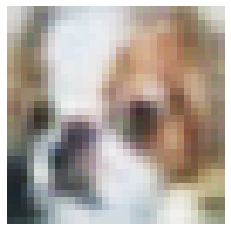

In [ ]:
'''
Backdoor samples filtering and purification effect
'''
os.mkdir('./bk') 
os.mkdir('./res')
os.mkdir('./coverbk')
show_num = 0
num = str(1)
now_class_num = num
with open("bk_path2label.txt", "w") as f:
    for i in range(504):
        f.write("./cifar10_dataset/bk_data/" + str(i+1)+".png "+num+"\n")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
print('BK Sample Example:')
path = './cifar10_dataset/bk_data/'+str(show_num+1)+'.png'
img = Image.open(path).convert('RGB')
img = img.resize((32 ,32))
plt.imshow(img)
plt.show()

print('-'*10)
print('')

model = ResNet34(10)
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load(model_addr))
weight_n = model.wn.wn.data.cpu().numpy() 
weight_score = show_weight(weight_n)  
x_raw, y_raw, attack_feature,err_num = getCAMdata("./bk_path2label.txt", label=1, model=model)


path = "./bk_path2label.txt"
save_filepath = "./coverbk/"
attack_details, attack_details_act, res_details_act_cam = getdetails_percent(attack_feature, weight_n, x_raw, y_raw,path,save_filepath,erase_method = 'repair',percent=threshold,target_label=False) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
print('BK Erasure Repair Sample Example:')
path = './coverbk/'+str(show_num)+'.png'
img = Image.open(path).convert('RGB')
img = img.resize((32 ,32))
plt.imshow(img)
plt.show()
print('-'*10)
print('')

true_label = 1
num = str(1)
bk_sample_sum=504
with open("coverbk_path2label.txt", "w") as f:
    for i in range(504):
        f.write("./coverbk/" + str(i)+".png "+num+"\n")



coverbk_data = MyDataset(txt="./coverbk_path2label.txt", 
              transform=transforms.Compose([
                transforms.Resize([32,32]),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
              )

coverbk_loader = DataLoader(coverbk_data, batch_size=50, shuffle=False)

model = ResNet34(10)
if torch.cuda.is_available():
    model = model.cuda()
model.load_state_dict(torch.load(model_addr))

torch.manual_seed(1)
model = model.eval()
pred = np.array([])
y_sum = np.array([])
with torch.no_grad():
    running_correct = 0
    total = 0 

    for x, label in coverbk_loader:
        data = x
        data = data.cuda()
        y_label = label
        y_label = y_label.type(torch.LongTensor)
        y_label = y_label.cuda()
        out,filter = model(data)
        _, predicted = torch.max(out.data, 1)
        total = total + y_label.size(0)
        running_correct = running_correct + (predicted == y_label).sum()
        predicted = predicted.cpu().numpy()
        pred = np.append(pred, predicted)
        y_sum = np.append(y_sum,y_label.cpu().numpy())

    print('\nBK FAR：%f%%' %(100 * running_correct / total))
    pred = list(pred)
    pass_num = [] 
    no_pass_num = []
    for i in range(len(pred)):
      if pred[i] == true_label:
        pass_num.append(i)
      else:
        no_pass_num.append(i)

bk_sample_pass = len(pass_num)
bk_sample_nopass = len(no_pass_num)

with open("./bk_path2label.txt",'r') as f:
  data = f.readlines()
  sample_nums = len(data)
  new_data = []
  new_data_res = []
  for i in range(len(data)):
    data[i] = data[i].strip('\n')
    data[i] = data[i][:-2]
    # print(data[i])
    if i in pass_num:
      new_data.append(data[i])
    else:
      new_data_res.append(data[i])
origin_num = len(new_data)
AE_num = len(new_data_res) 

for i in range(len(new_data)):
  img = cv2.imread(new_data[i])
  cv2.imwrite('./bk/bk_'+str(i)+'.png',img)

for i in range(len(new_data_res)):
  img = cv2.imread(new_data_res[i])
  cv2.imwrite('./res/'+str(i)+'.png',img)

num = str(now_class_num)
with open("res_path2label.txt", "w") as f:
    for i in range(len(new_data_res)):
        f.write("./res/" + str(i)+".png "+num+"\n")

device = torch.device('cuda')
AE_model = AE().to(device)
AE_model.load_state_dict(torch.load("./try_AE/pkl/AE_model.pkl"))
UNet_model = UNet(n_channels=3, n_classes=3).to(device) 
UNet_model.load_state_dict(torch.load("./try_AE/pkl/UNet_model.pkl"))

AE_model = AE_model.cuda()
UNet_model = UNet_model.cuda()
res_data = MyDataset(txt="./res_path2label.txt", 
              transform=transforms.Compose([
                transforms.Resize([32,32]),
                transforms.ToTensor()])
              )
res_loader = DataLoader(res_data, batch_size=40, shuffle=False)
x,y = iter(res_loader).next()
write_addr = './bk/'
xuhao = 0

with torch.no_grad():
  for batchidx, (x, _) in enumerate(res_loader):
    x = x.cuda()
    out = AE_model(x)
    out = out.cpu().numpy()
    for i in range(out.shape[0]):
      img = out[i]
      img = img*255
      img = img.transpose((1, 2, 0))  # chw -> hwc
      img = img[:,:,::-1]
      cv2.imwrite(write_addr+'bk_AE'+str(xuhao)+".png",img)
      xuhao+=1
print('-'*10)
print('')      
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
print('BK Erasure Repair Sample Example:')
path = write_addr+'bk_AE'+str(show_num)+'.png'
img = Image.open(path).convert('RGB')
img = img.resize((32 ,32))
plt.imshow(img)
plt.show()


## Dataset filtering and purification effect

Class0:
Class0 Erasure Repair Sample Example:


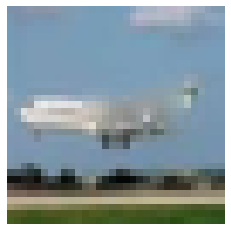

Class0 EXPAND√
class0 TAR： 0.9636699676375404
class0 Purification completed
class0 Purified Sample Example:


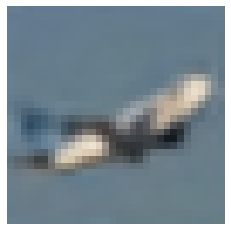

----------


Class1:
Class1 Erasure Repair Sample Example:


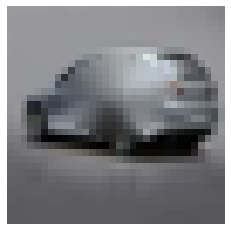

Class1suspicious and do not expand.
class1 TAR： 0.7304799999999999
class1 Purification completed
class1 Purified Sample Example:


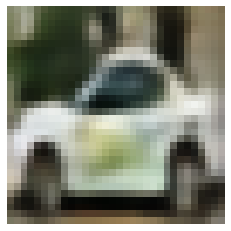

----------


Class2:
Class2 Erasure Repair Sample Example:


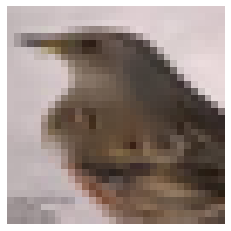

Class2 EXPAND√
class2 TAR： 0.9387913268608413
class2 Purification completed
class2 Purified Sample Example:


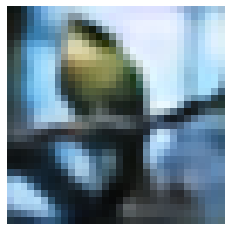

----------


Class3:
Class3 Erasure Repair Sample Example:


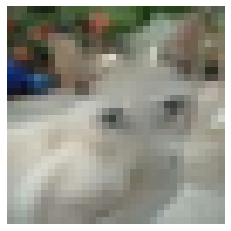

Class3 EXPAND√
class3 TAR： 0.9600291909385112
class3 Purification completed
class3 Purified Sample Example:


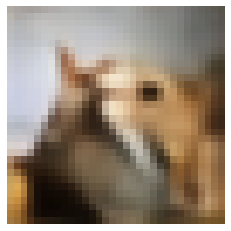

----------


Class4:
Class4 Erasure Repair Sample Example:


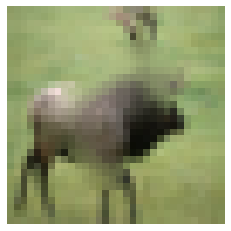

Class4 EXPAND√
class4 TAR： 0.927868996763754
class4 Purification completed
class4 Purified Sample Example:


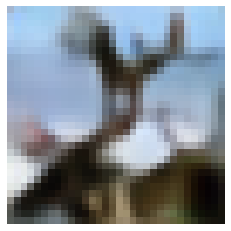

----------


Class5:
Class5 Erasure Repair Sample Example:


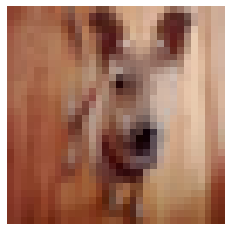

Class5 EXPAND√
class5 TAR： 0.9596246601941747
class5 Purification completed
class5 Purified Sample Example:


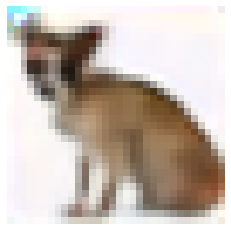

----------


Class6:
Class6 Erasure Repair Sample Example:


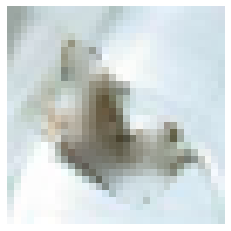

Class6 EXPAND√
class6 TAR： 0.8750777346278317
class6 Purification completed
class6 Purified Sample Example:


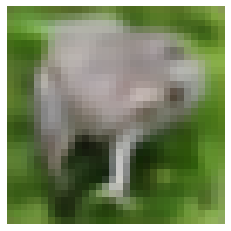

----------


Class7:
Class7 Erasure Repair Sample Example:


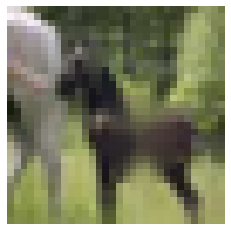

Class7 EXPAND√
class7 TAR： 0.9292848543689319
class7 Purification completed
class7 Purified Sample Example:


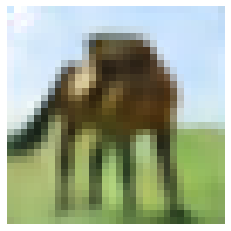

----------


Class8:
Class8 Erasure Repair Sample Example:


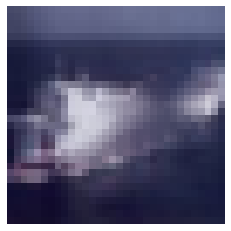

Class8 EXPAND√
class8 TAR： 0.946275145631068
class8 Purification completed
class8 Purified Sample Example:


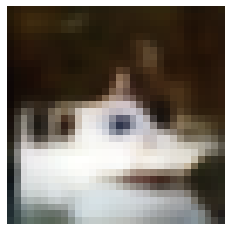

----------


Class9:
Class9 Erasure Repair Sample Example:


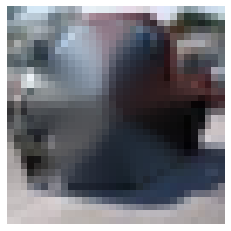

Class9 EXPAND√
class9 TAR： 0.8948997411003236
class9 Purification completed
class9 Purified Sample Example:


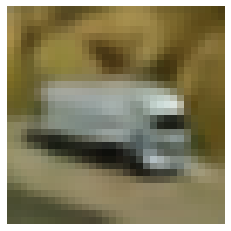

----------




In [ ]:
'''
Dataset filtering and purification effect. 
(Class1 is injected with backdoor samples.)
'''
for k in range(10):
  os.mkdir('./cover'+str(i))
  os.mkdir('./'+str(i)) 
for k in range(10):
  print('Class'+str(k)+':')
  shutil.rmtree("./res") 
  shutil.rmtree("./AE_sample") 
  os.mkdir("./res")
  os.mkdir("./AE_sample")
  now_class_num = str(k)

with open("try_path2label.txt", "w") as f:
  for imagename in os.listdir('./cifar10_dataset/train_bk/'+now_class_num):
    dst = './cifar10_dataset/train/'+now_class_num + '/' + imagename
    f.write(dst +" "+now_class_num+"\n")


  model = ResNet34(10)
  if torch.cuda.is_available():
      model = model.cuda()
  model.load_state_dict(torch.load(model_addr))
  weight_n = model.wn.wn.data.cpu().numpy()  
  weight_score = show_weight(weight_n) 
  x_raw, y_raw, attack_feature,err_num = getCAMdata("./try_path2label.txt", label=int(now_class_num), model=model) 

  print('Class' + now_class_num + ' Erasure Repair Sample Example:')
  path = "./try_path2label.txt"
  save_filepath = "./cover"+now_class_num+"/"
  attack_details, attack_details_act, res_details_act_cam = getdetails_percent(attack_feature, weight_n, x_raw, y_raw,path,save_filepath,erase_method = 'repair',percent=threshold,target_label=False) 
  shutil.move("./cover"+now_class_num+"/" , cover_dest_directory)
  fig, ax=plt.subplots()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.axis('off')
  path = cover_dest_directory+'cover'+now_class_num+'/0.png'
  img = Image.open(path).convert('RGB')
  img = img.resize((32 ,32))
  plt.imshow(img)
  plt.show()

  with open("cover_path2label.txt", "w") as f:
      for imagename in os.listdir('./cover_data/cover'+now_class_num):
        dst = './cover_data/cover'+now_class_num + '/' + imagename
        f.write(dst +" "+now_class_num+"\n")

  cover_data = MyDataset(txt='./cover_path2label.txt', transform=transforms.Compose([
              transforms.Resize([32,32]),
              transforms.ToTensor(),
              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
            )
  cover_loader = DataLoader(cover_data, batch_size=50, shuffle=False)
  true_label = int(now_class_num)
  model = ResNet34(10)
  if torch.cuda.is_available():
      model = model.cuda()
  model.load_state_dict(torch.load(model_addr))

  torch.manual_seed(1)
  model = model.eval()
  pred = np.array([])
  y_sum = np.array([])

  with torch.no_grad():
      running_correct = 0  
      total = 0  
      for x, label in cover_loader:
          data = x
          data = data.cuda()
          y_label = label
          y_label = y_label.type(torch.LongTensor)
          y_label = y_label.cuda()
          out,filter = model(data)
          _, predicted = torch.max(out.data, 1)
          total = total + y_label.size(0)
          running_correct = running_correct + (predicted == y_label).sum()
          predicted = predicted.cpu().numpy()
          pred = np.append(pred, predicted)
          y_sum = np.append(y_sum,y_label.cpu().numpy())
      pred = list(pred)
      pass_num = []
      no_pass_num = []
      for i in range(len(pred)):
        if pred[i] == true_label:
          pass_num.append(i)
        else:
          no_pass_num.append(i)
  j=0
  if err_num!=[]:
    for i in range(len(pass_num)-1):
      if err_num[j]>pass_num[i] and err_num[j]<pass_num[i+1]:
        pass_num.insert(i+1,err_num[j])
        j+=1
      elif err_num[j]==pass_num[i]:
        j+=1
      if j == len(err_num):
        break

  device = torch.device('cuda')
  AE_model = AE().to(device)
  AE_model.load_state_dict(torch.load("./try_AE/pkl/AE_model.pkl"))
  UNet_model = UNet(n_channels=3, n_classes=3).to(device) 
  UNet_model.load_state_dict(torch.load("./try_AE/pkl/UNet_model.pkl"))
  UNet_model2 = UNet(n_channels=3, n_classes=3).to(device) 
  UNet_model2.load_state_dict(torch.load("./try_AE/pkl/UNet_model2.pkl"))
  AE_model = AE_model.to(device)
  UNet_model, UNet_model2 = UNet_model.to(device), UNet_model2.to(device)
  res_data = MyDataset(txt="./try_path2label.txt", 
                transform=transforms.Compose([
                  transforms.Resize([32,32]),
                  transforms.ToTensor()])
                )

  res_loader = DataLoader(res_data, batch_size=50, shuffle=False)
  x,y = iter(res_loader).next()
  write_addr = './AE_sample/'
  xuhao = 0

  with torch.no_grad():
    for batchidx, (x, _) in enumerate(res_loader):
      x = x.cuda()
      x1 = AE_model(x)
      out = UNet_model(x1)
      out = out.cpu().numpy()
      for i in range(out.shape[0]):
        img = out[i]
        img = img*255
        img = img.transpose((1, 2, 0))  # chw -> hwc
        img = img[:,:,::-1]
        cv2.imwrite(write_addr+'AE'+str(xuhao)+".png",img)
        xuhao+=1

  num = now_class_num
  for root, dirs, files in os.walk(r"./AE_sample"):
      with open("tryAE_path2label.txt", "w") as f:
          for i in range(len(files)):
              f.write("./AE_sample/AE" + str(i)+".png "+num+"\n")
  model = ResNet34(10)

  if torch.cuda.is_available():
      model = model.cuda()
  model.load_state_dict(torch.load(model_addr))
  weight_n = model.wn.wn.data.cpu().numpy() 
  weight_score = show_weight(weight_n) 
  x_raw, y_raw, attack_feature,AE_err_num = getCAMdata("./tryAE_path2label.txt", label=int(now_class_num), model=model) 

  AE_num = []
  for i in range(attack_feature.shape[0]):
    if i not in AE_err_num:
      AE_num.append(i)


  count_AE =0
  for i in range(len(no_pass_num)):
    if no_pass_num[i] in AE_num:
      count_AE+=1

  if k != target_label:
    if ((len(AE_num)-count_AE)/len(pass_num))-(count_AE/len(no_pass_num)) < AE_threshold:
      print('Class'+ now_class_num + ' EXPAND√')
      pass_num = list(set(pass_num).union(set(AE_num)))
  else:
    if ((len(AE_num)-count_AE)/len(pass_num))-((count_AE+bk_sample_pass)/(len(no_pass_num)+bk_sample_nopass)) < AE_threshold:
      print('Class'+ now_class_num + ' EXPAND√')
      pass_num = list(set(pass_num).union(set(AE_num)))
    else:
      print('Class'+ now_class_num + 'suspicious and do not expand.')

  print('class'+ now_class_num + ' TAR：',len(pass_num)/attack_feature.shape[0] )
  total_TAR += len(pass_num)/attack_feature.shape[0]
  TAR = len(pass_num)/attack_feature.shape[0]

  with open('./try_path2label.txt','r') as f:
    data = f.readlines()
    sample_nums = len(data)
    new_data = []
    new_data_res = []
    for i in range(len(data)):
      data[i] = data[i].strip('\n')
      data[i] = data[i][:-2]
      if i in pass_num:
        new_data.append(data[i])
      else:
        new_data_res.append(data[i])

  for i in range(len(new_data)):
    img = cv2.imread(new_data[i])
    cv2.imwrite('./new/'+str(i)+'.png',img)

  with open("new_path2label.txt", "w") as f:
      for i in range(len(new_data)):
          f.write("./new/" +
                  str(i)+".png "+now_class_num+"\n")

  n_data = MyDataset(txt="./new_path2label.txt", 
                transform=transforms.Compose([
                  transforms.Resize([32,32]),
                  transforms.ToTensor()])
                )

  n_loader = DataLoader(n_data, batch_size=50, shuffle=False)
  write_addr = './'+str(now_class_num)+'/'
  xuhao = 0

  with torch.no_grad():
    for batchidx, (x, _) in enumerate(n_loader):
      x = x.cuda()
      out = UNet_model2(x)
      out = out.cpu().numpy()
      
      for i in range(out.shape[0]):
        img = out[i]
        img = img*255
        img = img.transpose((1, 2, 0))  # chw -> hwc
        img = img[:,:,::-1]
        cv2.imwrite(write_addr+'n'+str(xuhao)+".png",img)
        xuhao+=1

  for i in range(len(new_data_res)):
    img = cv2.imread(new_data_res[i])
    cv2.imwrite('./res/'+str(i)+'.png',img)

  with open("res_path2label.txt", "w") as f:
      for i in range(len(new_data_res)):
          f.write("./res/" +
                  str(i)+".png "+now_class_num+"\n")

  res_data = MyDataset(txt="./res_path2label.txt", 
                transform=transforms.Compose([
                  transforms.Resize([32,32]),
                  transforms.ToTensor()])
                )

  res_loader = DataLoader(res_data, batch_size=50, shuffle=False)
  write_addr = './'+str(now_class_num)+'/'
  xuhao = 0

  with torch.no_grad():
    for batchidx, (x, _) in enumerate(res_loader):
      x = x.cuda()
      x1 = AE_model(x)
      out = UNet_model(x1)
      out = out.cpu().numpy()
      
      for i in range(out.shape[0]):
        img = out[i]
        img = img*255
        img = img.transpose((1, 2, 0))  # chw -> hwc
        img = img[:,:,::-1]
        cv2.imwrite(write_addr+'AE'+str(xuhao)+".png",img)
        xuhao+=1
  print('class' + now_class_num+' Purification completed')

  print('class'+ now_class_num + ' Purified Sample Example:')
  path = './'+str(now_class_num)+'/AE1.png'
  fig, ax=plt.subplots()
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  plt.axis('off')
  img = Image.open(path).convert('RGB')
  img = img.resize((32 ,32))
  plt.imshow(img)
  plt.show()

  import shutil
  shutil.move('./'+ str(now_class_num) +'/' , final_dest_directory)
  print('-'*10)
  print('\n')

In [ ]:
print('TAR:',(total_TAR)/10)

TAR: 0.9126001618122975
